In [26]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
import pandas as pd
from google.cloud import bigquery
%matplotlib inline
from flask import request, jsonify

In [3]:
client = bigquery.Client.from_service_account_json("../../airqo-250220-c81b55f1dc21.json")

In [22]:
def get_static_channels():
    sql = """
        SELECT channel_id 
        FROM `airqo-250220.thingspeak.channel` 
        WHERE NOT LOWER(name) LIKE '%mobile%' 
        LIMIT 1000
    """
    channels = [channel.channel_id for channel in client.query(sql).result()]
    return channels

def get_df(channel_id):
    sql = """
    SELECT * FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE channel_id={}
    """.format(channel_id)

    df = client.query(sql).to_dataframe()
    return df

def get_loc(channel_id):
    sql = """
    SELECT channel_id, longitude, latitude 
    FROM `airqo-250220.thingspeak.channel`
    WHERE channel_id={}
    """.format(channel_id)

    df = client.query(sql).to_dataframe()
    
    return df

def get_entries_since(channel_id,daysago=7):
    from datetime import datetime,timedelta
    datestring = (datetime.now()-timedelta(daysago)).strftime("%Y-%m-%d %H:%M:%S") # current date and time

    sql = """
    SELECT created_at, channel_id, pm2_5 
    FROM `airqo-250220.thingspeak.clean_feeds_pms` 
    WHERE channel_id={} 
    AND created_at > '{}'
    """.format(channel_id,datestring)

    df = client.query(sql).to_dataframe() 
    
    return df

def get_xy():
    channels = get_static_channels()
    X = []
    Y = []
    for chan in channels:
        d = get_entries_since(chan)
        if d["created_at"].shape[0] == 0:
            continue
        else:
            d = d.set_index("created_at")
            d = d.resample("H").mean().reset_index()
            loc = get_loc(chan)
            X.append(np.array(loc)[:,1:])
            Y.append(np.mean(d['pm2_5']))
        Xtraining = np.array(X)[:,0,:]
        Ytraining = np.array(Y)[:,None]
        keep = ~np.isnan(Ytraining[:,0])
        Ytraining = Ytraining[keep,:]
        Xtraining = Xtraining[keep,:]
            
    return X,Y, Xtraining, Ytraining

def train_model(Xtraining,Ytraining):
    k = gpflow.kernels.RBF() + gpflow.kernels.Bias()
    #Ytraining = Ytraining - np.mean(Ytraining)
    m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=k, mean_function=None)
    m.kernel.kernels[0].lengthscales.assign(0.01) #~300m ->
    m.kernel.kernels[0].variance.assign(1000)
    m.likelihood.variance.assign(0.1)
    from gpflow import set_trainable
    set_trainable(m.kernel.kernels[0].lengthscales, False) #thanks Pablo!!!! YAY

    opt = gpflow.optimizers.Scipy()
    def objective_closure():
        return - m.log_marginal_likelihood()

    opt_logs = opt.minimize(objective_closure,
                            m.trainable_variables,
                            options=dict(maxiter=100))

    #m.kernel.lengthscales.assign(0.005)
    return m 

def get_preds(model):

    Xtest = np.meshgrid(np.linspace(32.4,32.8,150),np.linspace(0.1,0.5,150))
    Xtestflat = np.c_[Xtest[0].flatten(),Xtest[1].flatten()]
    predmeans,predvars = model.predict_f(Xtestflat)
    
    return predmeans,predvars,Xtest

In [19]:
X,Y,Xtraining,Ytraining = get_xy()
model = train_model(Xtraining, Ytraining)
premeans,predvars,Xtest = get_preds(model)

In [123]:
from flask import Flask, current_app
import json

app = Flask(__name__)

X1 = Xtraining[:,0].tolist()
with app.app_context():
    # within this block, current_app points to app.
    a = jsonify({"means":predmeans.numpy().tolist(),
                 "vars":predvars.numpy().tolist(),
                 "Xtest0":Xtest[0].tolist(),
                 "Xtest1":Xtest[1].tolist(),
                 "Xtraining0":Xtraining[:,0].tolist(),
                 "Xtraining1":Xtraining[:,1].tolist()})

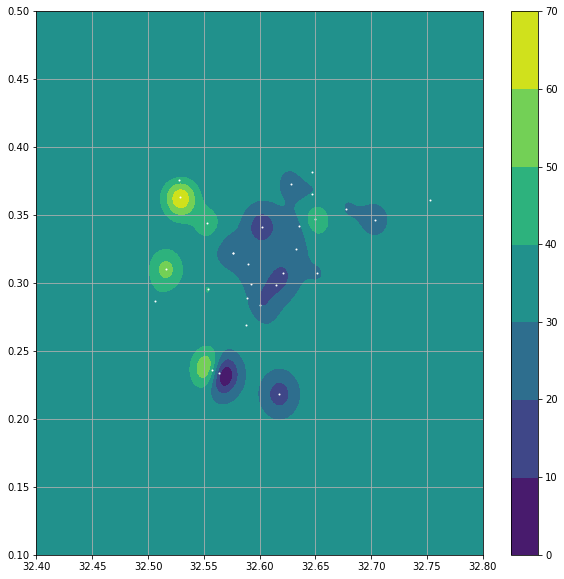

In [118]:
plt.figure(figsize=[10,10])

plt.xlim([32.4,32.8])
plt.ylim([0.1,0.5])
plt.contourf(Xtest[0],Xtest[1],predmeans.numpy().reshape([150,150]))
plt.colorbar()
plt.scatter(Xtraining[:,0],Xtraining[:,1],1,color='w')
plt.grid()

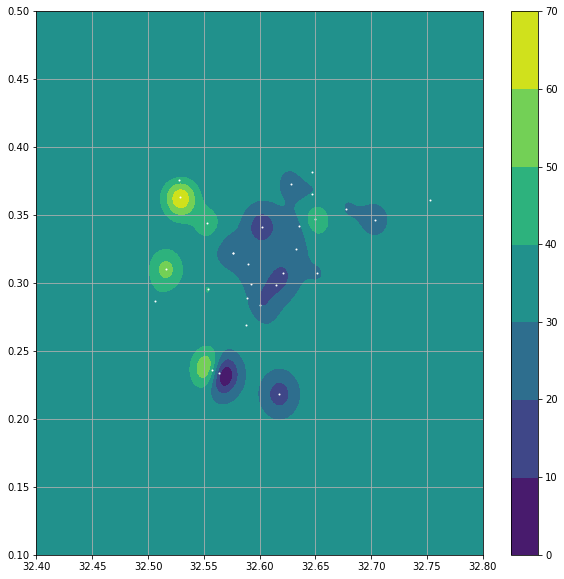

In [133]:
plt.figure(figsize=[10,10])

plt.xlim([32.4,32.8])
plt.ylim([0.1,0.5])
plt.contourf(a.get_json()["Xtest0"],a.get_json()["Xtest1"],np.asarray(a.get_json()["means"]).reshape(150,150))
plt.colorbar()
plt.scatter(a.get_json()["Xtraining0"],a.get_json()["Xtraining1"],1,color='w')
plt.grid()

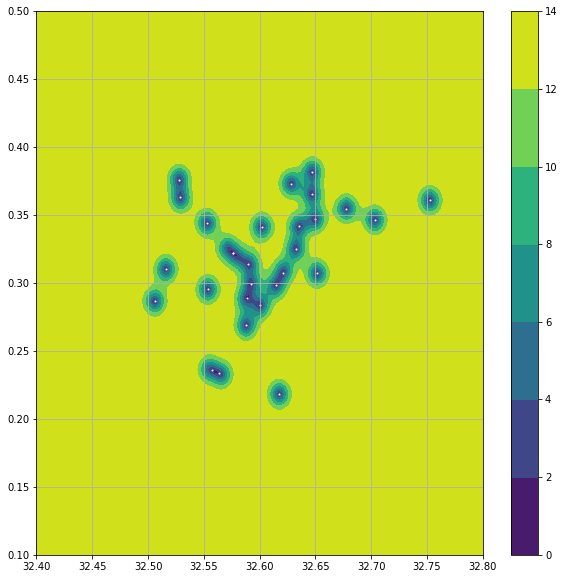

In [136]:
plt.figure(figsize=[10,10])

plt.xlim([32.4,32.8])
plt.ylim([0.1,0.5])
plt.contourf(a.get_json()["Xtest0"],a.get_json()["Xtest1"],np.sqrt(np.asarray(a.get_json()["vars"])).reshape(150,150))
plt.colorbar()
plt.scatter(a.get_json()["Xtraining0"],a.get_json()["Xtraining1"],1,color='w')
plt.grid()

In [143]:
b = np.asarray(a.get_json()["vars"]).reshape(150,150)
c = predvars.numpy().reshape([150,150])
np.nonzero(b-c)

(array([], dtype=int64), array([], dtype=int64))

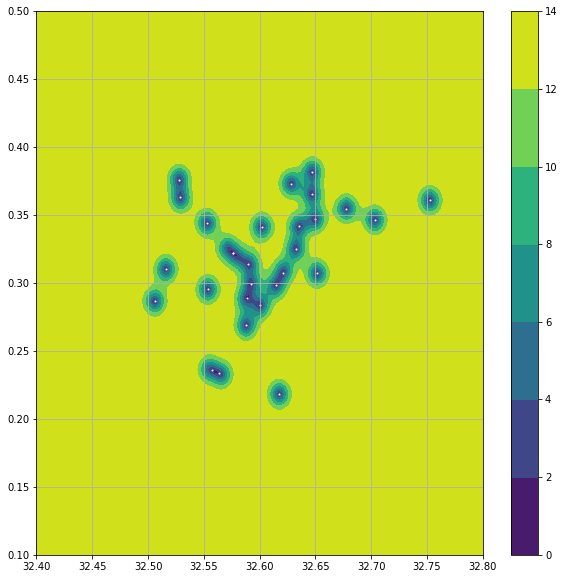

In [135]:
plt.figure(figsize=[10,10])

plt.xlim([32.4,32.8])
plt.ylim([0.1,0.5])
plt.contourf(Xtest[0],Xtest[1],np.sqrt(predvars.numpy()).reshape([150,150]))
plt.colorbar()
plt.scatter(Xtraining[:,0],Xtraining[:,1],1,color='w')
plt.grid()